# Customer Churn Clustering
The following dataset represents customer data that we are trying to clean, transform and cluster to identify groups of customers that help us understand their behavior regarding the retention. 

From there we can formulate recommendations to create customer retention programs

In [ ]:
# Import relevant libraries 
import pandas as pd 
pd.options.display.float_format = '{:.2f}'.format
import numpy as np 
np. set_printoptions(suppress=True)
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import plotly.express as px
from math import sin, cos, pi

## Data Exploration 

In [ ]:
# Importing the data 
## We will set the customerID column right away as ID, since it won't increase predictive capability of our model
customer_data_raw = pd.read_csv('https://raw.githubusercontent.com/lucamarcelo/Churn-Modeling/main/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

print('Our dataframe has {} rows and {} columns.'.format(customer_data_raw.shape[0], customer_data_raw.shape[1]))

Our dataframe has 7043 rows and 20 columns.


In [ ]:
# Looking at the dataframe

customer_data_raw.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Checking for duplicates and missing values 

print('Our dataframe has {} duplicates and there are {} missing values.'.format(np.sum(customer_data_raw.duplicated()),  customer_data_raw.isnull().sum().sum()))

# Dropping duplicates
customer_data_raw.drop_duplicates(inplace=True)
print('After dropping the duplicates, our dataframe has {} duplicates and {} missing values.'.format(np.sum(customer_data_raw.duplicated()),  customer_data_raw.isnull().sum().sum()))

Our dataframe has 22 duplicates and there are 0 missing values.
After dropping the duplicates, our dataframe has 0 duplicates and 0 missing values.


In [ ]:
# What types of data do we have in our dataframe? 

print( 'In our dataframe there are the following datatypes:\n{}'.format(customer_data_raw.dtypes) )

In our dataframe there are the following datatypes:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


As we can see for now, most of our features in the dataframe are object, i.e. text, and just a few are numerical. We can also see that `TotalCharges` is encoded as text, which is likely to be wrong.

### Looking at distributions

In [ ]:
# Get summary of numerical variables
customer_data_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7021.00,7021.00,7021.00
mean,0.16,32.47,64.85
std,0.37,24.53,30.07
min,0.00,0.00,18.25
25%,0.00,9.00,35.75
50%,0.00,29.00,70.40
75%,0.00,55.00,89.90
max,1.00,72.00,118.75


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



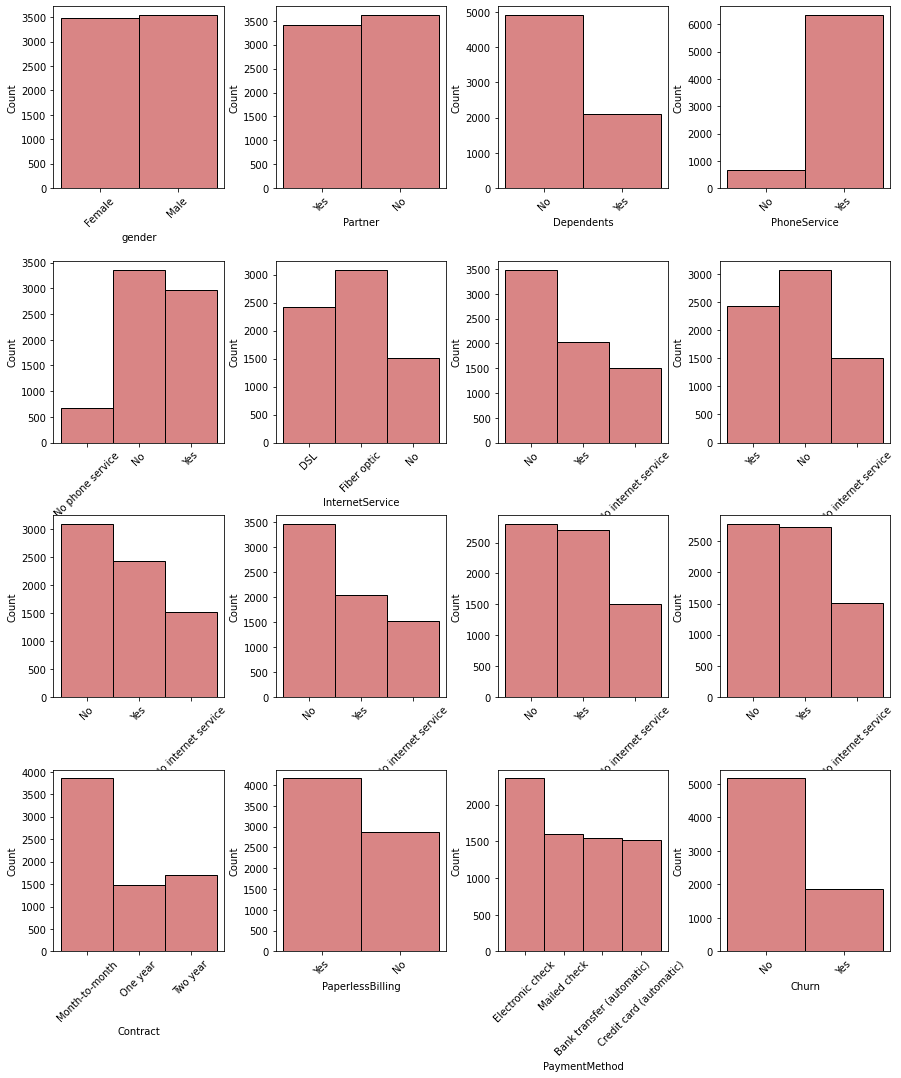

In [ ]:
# Visualizing categorical variables with barcharts 

categorical_variables = customer_data_raw.select_dtypes(exclude=np.number)
categorical_variables.drop('TotalCharges', axis=1,inplace=True) # we leave TotalCharges out, since it's actually a numerical variable

fig, ax = plt.subplots(4, 4, figsize=(15, 15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)
for variable, subplot in zip(categorical_variables.columns, ax.flatten()):
    sns.histplot(categorical_variables[variable], ax=subplot, color='indianred')
    for label in subplot.get_xticklabels():
        label.set_rotation(45)    

In [ ]:
# Checking the cardinality of categorical variables, i.e. how many unique values they have

def unique_per_col(df): 
    #Selecting only categorical cols
    cols = (df.dtypes == 'object')
    object_cols = list(cols[cols].index)
    #Count unique values
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    d = dict(zip(object_cols, object_nunique))
    #Print number of unique entries by column, in ascending order
    for row in sorted(d.items(), key=lambda x: x[1]):
        print(row)
    
# Calling the function 
unique_per_col(customer_data_raw)

('gender', 2)
('Partner', 2)
('Dependents', 2)
('PhoneService', 2)
('PaperlessBilling', 2)
('Churn', 2)
('MultipleLines', 3)
('InternetService', 3)
('OnlineSecurity', 3)
('OnlineBackup', 3)
('DeviceProtection', 3)
('TechSupport', 3)
('StreamingTV', 3)
('StreamingMovies', 3)
('Contract', 3)
('PaymentMethod', 4)
('TotalCharges', 6531)


## Preprocessing
In order to be able to work with the data, we need to preprocess it. This will include: 
- Checking for missing values
- Look at encoding of variables (Are the variables in the right datatype?)
- Encoding of categorical variables (converting them to numerical)

As far as the encoding goes (and also the scaling), which needs to be done in order for the PCA algorithm to work with the data, we will do it in the following sections creating a *pipeline*. 

Before doing anthing though, we need to convert `TotalCharges` to a numeric datatype.

In [ ]:
# Convert TotalCharges

customer_data_raw['TotalCharges'] = pd.to_numeric(customer_data_raw['TotalCharges'], errors='coerce')

# Since some of the values weren't filled in correctly, we create NaNs, that have to be filled now. 
# We will use the median to impute those values
print('The rows with NaNs have the following IDs: \n', customer_data_raw.TotalCharges[customer_data_raw['TotalCharges'].isnull()])

# Imputation by median
customer_data_raw['TotalCharges'].fillna(customer_data_raw['TotalCharges'].median(), inplace=True) 

# Check again
print('After imputation we have the followning NaNs: \n', customer_data_raw.TotalCharges[customer_data_raw['TotalCharges'].isnull()])

The rows with NaNs have the following IDs: 
 customerID
4472-LVYGI   nan
3115-CZMZD   nan
5709-LVOEQ   nan
4367-NUYAO   nan
1371-DWPAZ   nan
7644-OMVMY   nan
3213-VVOLG   nan
2520-SGTTA   nan
2923-ARZLG   nan
4075-WKNIU   nan
2775-SEFEE   nan
Name: TotalCharges, dtype: float64
After imputation we have the followning NaNs: 
 Series([], Name: TotalCharges, dtype: float64)


### Missing Values

In [ ]:
def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        #empty = round((data[data[col]] == '').sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col,
                                     len(unique_values),
                                     nans,
                                     zeros,
                                     #empty
                                    ]).T, ignore_index = True)

    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %',
                                #4: 'empty'
                               }).sort_values('Nan %', ascending=False)

missing_values(customer_data_raw)

,variable,Unique values,Nan %,zeros %
0,gender,2,0.00,0.00
1,SeniorCitizen,2,0.00,83.70
18,TotalCharges,6531,0.00,0.00
17,MonthlyCharges,1585,0.00,0.00
16,PaymentMethod,4,0.00,0.00
15,PaperlessBilling,2,0.00,0.00
14,Contract,3,0.00,0.00
13,StreamingMovies,3,0.00,0.00
12,StreamingTV,3,0.00,0.00
11,TechSupport,3,0.00,0.00


## Principal Component Analysis - PCA 
According to [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis) "principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest."<br>

*What does that mean?* <br>
PCA calculates *principal components* which are the vectors that retain the most variance in our dataset and can therefore best explain the variance within our dataset. [This video](https://www.youtube.com/watch?v=FgakZw6K1QQ) does an excellent job at explaining the main ideas and intuition behind PCA. 

*PCA is used for:* 
- Dimensionality Reduction
  - If we have a high-dimensional dataset (the one we're working with has 20 dimenions), it is computationally more expensive to create predictions. Moreover with a greater amount of features, there's a greater risk of overfitting. 
- Visualization (in EDA) --> This is what we're going to do here! 
  - We have 21 features, therefore we cannot visualize them (we can only visualize 3 dimensions)
  - PCA allows us to visualize our dataset along two or three most important principal components

*How many principal components do we need?*<br>
This depends a bit on how much variance we want to retain from the original data. Basically, the more components we use, the higher the amount of information (or variance) we can retain. The few components we use, the lower the amount of variance we retain.

*Creating the PCA workflow*<br>
As mentioned before, we will create a **pipeline** to do some preprocessing (encoding and scaling) before the PCA. By doing so we create cleaner code, minimize the sources of errors, and chain all the necessary steps together into a lean pipeline.

In [ ]:
# Performing PCA 

## Create feature matrix (drop target variable)
X = customer_data_raw.drop(['Churn'], axis=1)

# Creating pipeline objects 
## PCA
pca = PCA()
## Create columntransformer to encode and selectively scale features
categorical_ix = X.select_dtypes(exclude=np.number).columns # selecting categorical features

ct = ColumnTransformer([
        ('encoder', OneHotEncoder(), categorical_ix),
        ('scaler', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])
    ], remainder='passthrough')

# Create pipeline
pca_pipe = make_pipeline(ct,
                         pca)

# Fit data to pipeline
principal_components = pca_pipe.fit_transform(X)

PCA_df = pd.DataFrame(principal_components)
PCA_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,-1.24,-1.72,1.45,0.44,0.73,-0.74,1.37,0.10,1.31,-0.45,0.07,0.17,-0.75,0.28,0.20,-0.21,-0.02,-0.12,-0.29,0.30,-0.45,0.47,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
1,-0.41,-0.28,1.34,-0.94,-0.73,0.34,-1.08,0.03,-0.79,-0.40,0.83,0.85,0.69,0.43,0.27,0.03,-0.13,0.72,0.31,0.14,0.04,-0.16,0.04,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
2,-1.16,-1.64,0.94,-0.51,-0.61,-0.10,-0.38,-1.37,0.78,0.34,0.03,0.87,-0.01,-0.09,-0.12,0.36,0.31,0.57,0.37,0.10,-0.03,-0.05,-0.03,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00
3,-0.24,0.29,2.30,-1.40,-0.72,0.23,0.03,0.62,-0.63,0.19,0.59,0.10,0.21,0.68,0.45,0.34,-0.72,-0.65,-0.98,0.03,-0.12,-0.21,0.05,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00
4,-0.74,-2.49,-0.41,0.01,0.67,-0.49,-0.23,-0.46,-0.47,-0.31,-0.01,-0.10,-0.02,-0.23,0.04,-0.27,-0.36,-0.11,-0.11,0.35,-0.23,0.08,0.02,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,0.91,0.30,0.53,0.80,-0.52,1.74,0.59,-0.19,-0.41,1.44,0.35,0.33,0.58,0.91,0.26,0.01,-0.02,0.59,0.43,0.04,0.17,-0.33,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00
7017,3.26,1.46,-0.64,0.79,0.65,-0.24,0.37,0.03,0.36,-0.68,0.42,-0.13,1.35,0.16,-0.22,-0.38,0.51,0.16,-0.09,-0.33,-0.25,0.24,-0.04,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
7018,-1.14,-1.24,1.99,1.23,0.79,-0.40,1.16,0.13,-0.05,0.43,-0.13,1.11,-0.12,-0.29,0.13,-0.30,-0.53,-0.19,-0.62,-0.07,-0.20,0.33,-0.01,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
7019,-0.32,-2.02,-0.27,0.96,-0.72,-0.84,-0.06,0.15,-0.15,0.66,0.36,-0.14,-0.43,0.66,0.07,0.31,0.73,0.80,-0.27,0.30,0.60,-0.09,-0.01,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00


Since now we have fitted the data to our pipeline, including doing the PCA, we can access the information inside of `pca_result`. We're going to be looking at the attributes `explained_variance_ratio_` which is the percentage of variance explained by each of the selected components.

In [ ]:
# Variance explained by each component and cumulative variance

print ("Proportion of Variance: \n", pca.explained_variance_ratio_)  
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
print ("\nCumulative Prop. Variance of first 10 components: \n", exp_var_cumul[:10])  

Proportion of Variance: 
 [0.28749983 0.19119027 0.07196787 0.04810795 0.04319151 0.03922156
 0.03619991 0.03152857 0.02693738 0.02606053 0.02382888 0.02241647
 0.02052781 0.01953747 0.0190496  0.01897214 0.01820306 0.01582969
 0.01414639 0.0111607  0.0096876  0.00468551 0.0000493  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

Cumulative Prop. Variance of first 10 components: 
 [0.28749983 0.4786901  0.55065797 0.59876592 0.64195743 0.68117899
 0.7173789  0.74890747 0.77584485 0.80190539]


### Plotting cumulative variance
This is basically a visually representation of the second print statement above and will give us an idea of how many components we need to get to the minimum threshold of 70%. 

In [ ]:
# Plotting cumulative variance

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Visualize the data across 3 principal components
Oftentimes we want to visualize the data. However if there's more than 3 variables (dimensions) we simply cannot visualize it therefore we need to project the data onto a lower-dimensional space.

That being sad in the following we will run PCA again, but only with three principal components. As we will see the retained variance decreases to only 55% compared to the original data.

In [ ]:
# We have to run the PCA again - this time with only three components

# Creating pipeline objects 
## PCA
pca_3d = PCA(n_components=3)
## Create columntransformer to only scale a selected set of featues
categorical_ix = X.select_dtypes(exclude=np.number).columns

ct = ColumnTransformer([
        ('encoder', OneHotEncoder(), categorical_ix),
        ('scaler', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])
    ], remainder='passthrough')

# Create pipeline
pca_pipe = make_pipeline(ct,
                         pca_3d)

# Fit data to pipeline
principal_components_3d = pca_pipe.fit_transform(X)


# Visualize data across the linear components

total_var = sum(pca_3d.explained_variance_ratio_)*100

fig = px.scatter_3d(
    principal_components_3d, x=0, y=1, z=2, color=customer_data_raw['Churn'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

As we can see above, with three principal component, we can only roughly explain *half* of the variance in the data. For visualization purpose we've decided to only include the first three components. However, ideally, we would like to explain at least around 70% of the variance.

In the following we will look at the loadings of the principal components. 


### Plotting loadings chart (also known as biplot)

In [ ]:
# Creating pipeline objects 
## PCA
pca = PCA(n_components=2)
## Create columntransformer to only scale a selected set of featues
categorical_ix = X.select_dtypes(exclude=np.number).columns

features = X.columns

ct = ColumnTransformer([
        ('encoder', OneHotEncoder(), categorical_ix),
        ('scaler', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])
    ], remainder='passthrough')

# Create pipeline
pca_pipe = make_pipeline(ct,
                         pca)

# Fit data to pipeline
pca_result = pca_pipe.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


# Visualize biplot
fig = px.scatter(pca_result, x=0, y=1, color=customer_data_raw['Churn'])

r = 2 # this can be modified as needed, and is in units of the axis
theta = 2*pi/len(features)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=r*sin(i*theta), 
        ay=r*cos(i*theta),
        axref="x",
        ayref="y",
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.show()


### Conclusions from PCA 

After doing the preprocessing and performing the PCA we can reach a few conclusions:
- The general hope of principal components analysis is that the first few components will account for a substantial proportion of the variation in the original variables. In our case, the explained variance seems to be to be very linearly increasing, i.e. even though the first components is the one that accounts for the largest variance, the actual amount is very low. This means that the first principal components account only for about 55% of the total variance.  
- Ideally we want to be able *at least 70%* of the total variance. Therefore, we would have to retain 7 components.


## Clustering

Cluster Analysis is an *unsupervised classification technique*, that tries to **group a dataset into two or more clusters** according to similar features. The goal is that the samples of a cluster are as similar as possible (*internal homogeneity*) and that the groups themselves are as different as possible (*external heterogenity*). 

In our case, with clustering, we hope to identify different customer groups and adapt, for example, our marketing strategy according to the needs of each individual group. The is also known customer segmentation, or profiling. 

Here we will be using the **K-means** algorithm, which is an unsupervised learning algorithm. It sets random points in the data and compares the mean of each cluster to the closest datapoints. *K* in this case is the number of clusters. The quality of the model is determined by the total variation. 
K=1 is the worst case, since it has the highest total variation. The more Ks we add, the lower the variation, but at a given point the variation doesn't go down as much, and that's when we have our Ks.

### Finding the right number of clusters
In the above visualizations, we can already roughly distinguish two clusters. However, we have to keep in mind, that we can only retain so much information with the first two or three principal components. 

Therefore we will use a method called **elbow plot** to find the right number of clusters. 

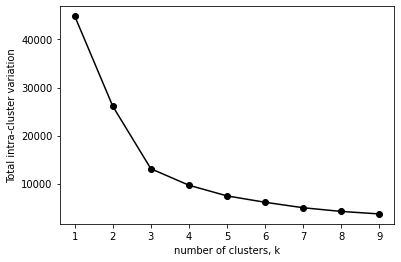

In [ ]:
# K-means and elbow plot

from sklearn.cluster import KMeans 

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('Total intra-cluster variation')
plt.xticks(ks)
plt.show()

From the above graph we can see that there's a clear "elbow" at k=3. This gives us an indication that in this case we should use ideally three clusters. 

In case it is not as clearly visible from the elbow plot, we can also use the **Silhouette methods**. The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

The Silhouette Score reaches its global maximum at the optimal k.



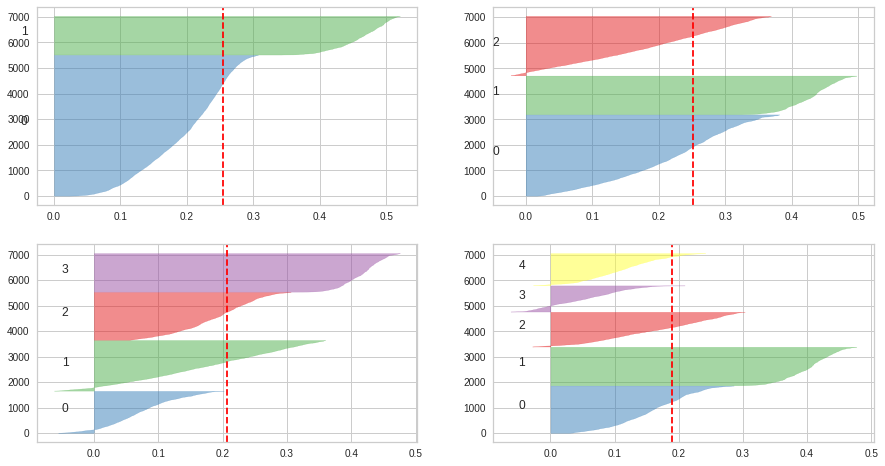

In [ ]:
# Silhouette method 

from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

X_scaled = ct.fit_transform(X)

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for k in [2, 3, 4, 5 ]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)

Now we have different Silhouette plots for 2, 3, 4, and 5 clusters. 
The thickness of the lines, on the one hand, shows us the size of the cluster, while the x-axis shows us the silhuette score. 

As we can see they're all very similar to each other, and none has an ideal score. However, it seems that n=2 or n=3 seems to be the best choice here, which is in line with what we saw in the elbow plot - at least for n=3. 

### Visualizing the clusters

Since we're dealing with a high-dimensional dataset, we cannot simply plot all the data. We've solved this problem with PCA previously. 

Therefore, we will only be able to visualize the clusters in a 2- or max 3-dimensional space. In other words we have to reduce the dimensionality with PCA and plot the clusters along the principal components. 

Text(0, 0.5, 'PCA 2')

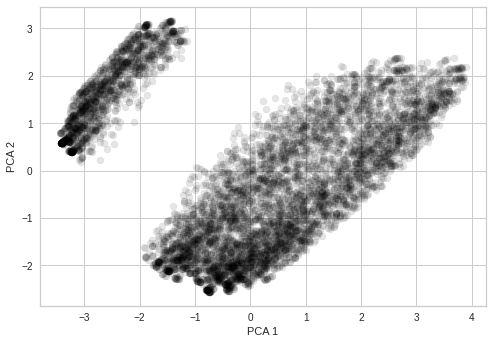

In [ ]:
# Visualizing the data as it is 

'''
As we can see, by simply plotting all the data, there are two visible plots, that we can identify. 
Let's see how it turns out with the cluster. 
'''

plt.scatter(PCA_df[0], PCA_df[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [ ]:
# Visualizing clusters

X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df['species'])
fig.show()



# We have to run the PCA again - this time with only three components

# Creating pipeline objects 
## PCA
pca_3d = PCA(n_components=3)
## Create columntransformer to only scale a selected set of featues
categorical_ix = X.select_dtypes(exclude=np.number).columns

ct = ColumnTransformer([
        ('encoder', OneHotEncoder(), categorical_ix),
        ('scaler', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])
    ], remainder='passthrough')

# Create pipeline
pca_pipe = make_pipeline(ct,
                         pca_3d)

# Fit data to pipeline
principal_components_3d = pca_pipe.fit_transform(X)


# Visualize data across the linear components

total_var = sum(pca_3d.explained_variance_ratio_)*100

fig = px.scatter_3d(
    principal_components_3d, x=0, y=1, z=2, color=customer_data_raw['Churn'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()